# Importing the dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional,Flatten, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [ ]:
def getUnreadableCount(df):
    return (df['IDENTITY'] == 'UNREADABLE').sum();

def getLowercaseCount(df):
    return (df['IDENTITY'].str.islower()).sum();

def getDigitCount(df):
    return (df['IDENTITY'].str.isdigit()).sum();
  
def removeUnreadableEntries(df):
    is_unreadable = df['IDENTITY'] != 'UNREADABLE';
    df = df[is_unreadable];
    return df;

def removeDigitEntries(df):
    is_digit = df['IDENTITY'].str.isdigit();
    df = df[is_digit];
    return df;

def cleanDataSet(df):
    empty_count = df.isnull().sum().sum();      # 565 for train, 78 for validation
    if(empty_count):
        df.dropna(inplace=True);
    unreadable_count = getUnreadableCount(df);  # 102 for train, 12 for validation
    if(unreadable_count):
        df = removeUnreadableEntries(df);
    digit_count = getDigitCount(df);            # 0 for train, 0 for validation
    if(digit_count):
        df = removeDigitEntries(df);
    lowercase_count = getLowercaseCount(df);    # 13 for train, 2 for validation
    if(lowercase_count):
        # Names in the pictures are all uppercase, we have to make our data uppercase
        df.loc[:, 'IDENTITY'] = df['IDENTITY'].apply(lambda x: x.upper());
    notpicture_count = df[~df["FILENAME"].str.endswith('.jpg')].sum().sum().astype(int);
    if(notpicture_count):                       # 0 for train, 0 for validation
         df = df[df["FILENAME"].str.contains('.jpg')];
    return df;

def num_to_char(num): 
    label = ""
    for ch in num:
        if ch == -1:
            break
        label+=alphabet_characters[ch]        
    return label

def ctc_loss_function(args):  
    y_pred, y_true, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [ ]:
train_size = 50000
valid_size= 10000
alphabet_characters = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
num_of_characters = len(alphabet_characters) + 1
num_of_timestamps = 64

In [ ]:
training_written_df = pd.read_csv('../raw_data/kaggled/written_name_train_v2.csv')
validation_written_df = pd.read_csv('../raw_data/kaggled/written_name_test_v2.csv')

In [9]:
training_written_df = cleanDataSet(training_written_df);
validation_written_df = cleanDataSet(validation_written_df);
    
# To make sure our indices are one behind the other
training_written_df.reset_index(inplace = True, drop=True)
validation_written_df.reset_index(inplace = True, drop=True) 

## Plotting

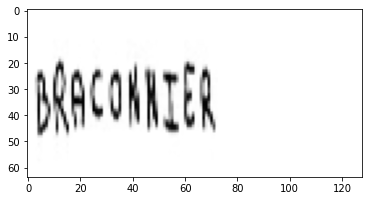

In [10]:
i = 128;
img_dir = '../raw_data/kaggled/train_v2/train/'+training_written_df.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(image, (128, 64))
plt.imshow(new_img, cmap = 'gray')
plt.show()

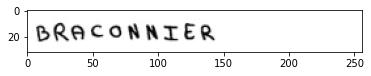

In [11]:
i = 128;
img_dir = '../raw_data/kaggled/train_v2/train/'+training_written_df.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(image, (256, 32))
plt.imshow(new_img, cmap = 'gray')
plt.show()

## Data preparation

In [17]:
valid_x = []
for i in range(valid_size):
    img_dir = '../raw_data/kaggled/validation_v2/validation/'+validation_written_df.loc[i, 'FILENAME']   
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    valid_x.append(image)
    
train_x = []
for j in range(train_size):
    img_dir = '../raw_data/kaggled/train_v2/train/'+training_written_df.loc[j, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    train_x.append(image)
    

valid_x = np.array(valid_x).reshape(-1, 256, 32, 1)
train_x = np.array(train_x).reshape(-1, 256, 32, 1)

str_len = training_written_df["IDENTITY"].str.len().max()

train_y = np.ones([train_size, str_len]) * -1

train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

valid_y = np.ones([valid_size, str_len]) * -1

valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-ucld1hvm/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [13]:
valid_x = np.array(valid_x).reshape(-1, 256, 32, 1)
train_x = np.array(train_x).reshape(-1, 256, 32, 1)

str_len = training_written_df["IDENTITY"].str.len().max()

NameError: name 'train_x' is not defined

In [14]:
train_y = np.ones([train_size, str_len]) * -1

train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

valid_y = np.ones([valid_size, str_len]) * -1

valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

NameError: name 'str_len' is not defined